In [32]:
import os
import sys
import time
import calendar
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from matplotlib.cm import coolwarm
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

def read_prices(directory, start_year, end_year):
    month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun',
                  'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    filenames = []
    for year in range(start_year, end_year + 1):
        for month in month_order:
            filename = f"ERCOT_{month}_{year}.csv"
            filepath = os.path.join(directory, filename)
            if os.path.exists(filepath):
                filenames.append(filepath)
    p_list = []
    times_list = []
    for file in filenames:
        df = pd.read_csv(file, usecols=['lmp_dam', 'interval_start_utc'], dtype={'lmp_dam': 'float64'})
        p_list.append(df['lmp_dam'].values)
        times_list.append(pd.to_datetime(df['interval_start_utc']))
    p = np.concatenate(p_list)
    return p

def repeat_single_year_data_with_leap_years(p, start_year=2000, end_year=2029):
    new_p_list = []
    for year in range(start_year, end_year + 1):
        if calendar.isleap(year):
            new_p_list.append(p)
        else:
            # Remove entries corresponding to February 29th
            p_non_leap = np.concatenate((p[:1416], p[1440:]))
            new_p_list.append(p_non_leap)
    new_p = np.concatenate(new_p_list)
    return new_p

def horizon(x, H):
    number_of_samples = len(x) - H
    future = np.zeros((number_of_samples,H))
    c = 0
    for i in range(len(x) - H):
        future_slice = x[i:i+H]
        future[c] = future_slice
        c += 1
    return future

def generate_intervals_2_weeks(year):
    intervals = []
    for month in [1,6]:
        start_time = f"{year}-{month:02d}-01 00:00"
        end_time = f"{year}-{month:02d}-07 23:00"
        intervals.append((start_time, end_time))
    return intervals

directory = '../ercot/prices'
single_year_prices = read_prices(directory, 2012, 2012)
single_year_times = pd.date_range(start='2012-01-01 00:00', end='2012-12-31 23:00', freq='h')
start_year = 2012
end_year = 2036
prices = repeat_single_year_data_with_leap_years(single_year_prices, start_year, end_year)
times = pd.date_range(start=f'{start_year}-01-01 00:00', end=f'{end_year}-12-31 23:00', freq='h')
assert len(prices) == len(times)
H = 24
f_test = horizon(prices, H)

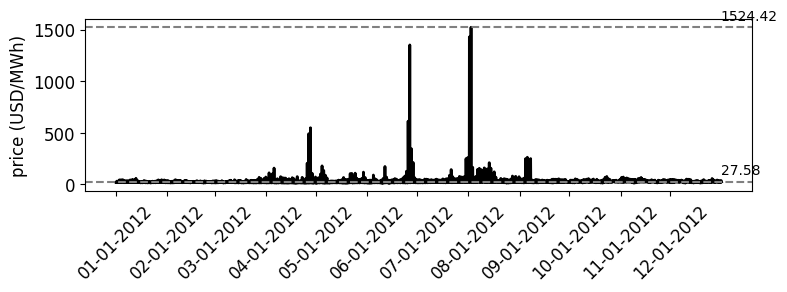

In [33]:
output_dir = "./figures"
os.makedirs(output_dir, exist_ok=True)
file_name = 'prices_ERCOT_2012.pdf'
file_path = os.path.join(output_dir, file_name)
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(single_year_times, single_year_prices, label='price', color='black', linewidth=2)
ax.set_ylabel(f'price (USD/MWh)', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(False)
ax.axhline(y=np.mean(single_year_prices), color='gray', linestyle='--', label='mean')
ax.axhline(y=np.max(single_year_prices), color='gray', linestyle='--', label='max')
ax.annotate(f'{np.mean(single_year_prices):.2f}', xy=(single_year_times[-10], np.mean(single_year_prices)), xytext=(0, 5), textcoords='offset points', color='black', fontsize=10)
ax.annotate(f'{np.max(single_year_prices):.2f}', xy=(single_year_times[-10], np.max(single_year_prices)), xytext=(0, 5), textcoords='offset points', color='black', fontsize=10)
ax.set_xticks(pd.date_range(start=single_year_times.min(), end=single_year_times.max(), freq='MS'))
ax.xaxis.set_major_formatter(DateFormatter('%m-%d-%Y'))
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
#plt.savefig(file_path, bbox_inches='tight')
plt.show()

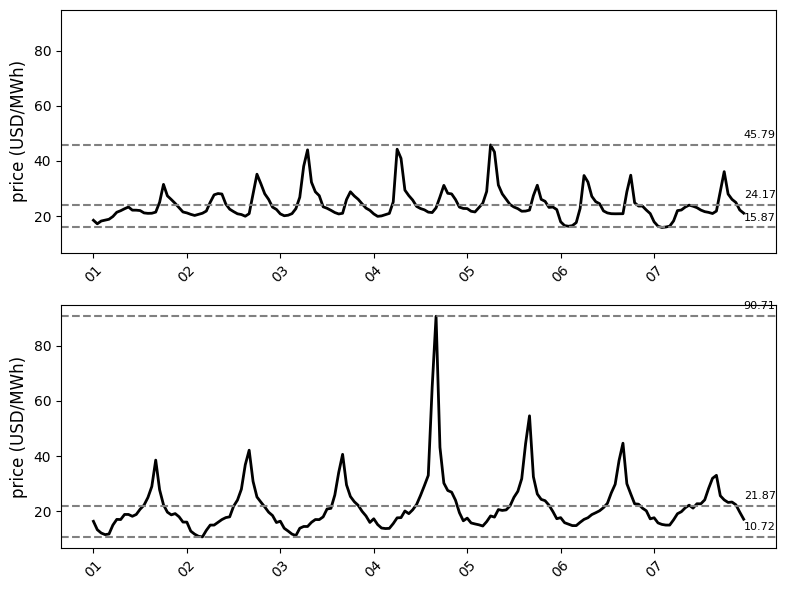

In [34]:
intervals = generate_intervals_2_weeks(2012)
output_dir = "./figures"
os.makedirs(output_dir, exist_ok=True)
file_name = 'prices_ERCOT_2012_weekly.pdf'
file_path = os.path.join(output_dir, file_name)
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharey=True)
axes = axes.flatten()
for idx, (start_time, end_time) in enumerate(intervals):
    mask = (times >= start_time) & (times <= end_time)
    p_subset = prices[mask]
    times_subset = times[mask]
    ax = axes[idx]
    if len(p_subset) > 0:
        ax.plot(times_subset, p_subset, label='Price', color='black', linewidth=2)
        ax.set_ylabel('price (USD/MWh)', fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.grid(False)
        ax.axhline(y=np.mean(p_subset), color='gray', linestyle='--')
        ax.axhline(y=np.max(p_subset), color='gray', linestyle='--')
        ax.axhline(y=np.min(p_subset), color='gray', linestyle='--')
        if len(times_subset) >= 10:
            ax.annotate(f'{np.mean(p_subset):.2f}', xy=(times_subset[-1], np.mean(p_subset)), xytext=(0, 5), textcoords='offset points', color='black', fontsize=8)
            ax.annotate(f'{np.max(p_subset):.2f}', xy=(times_subset[-1], np.max(p_subset)), xytext=(0, 5), textcoords='offset points', color='black', fontsize=8)
            ax.annotate(f'{np.min(p_subset):.2f}', xy=(times_subset[-1], np.min(p_subset)), xytext=(0, 5), textcoords='offset points', color='black', fontsize=8)
    ax.set_xticks(pd.date_range(start=start_time, end=end_time, freq='d'))
    ax.xaxis.set_major_formatter(DateFormatter('%d'))
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
#plt.savefig(file_path, bbox_inches='tight')
plt.show()

In [35]:
cell_constants = {
    'H' : H,
    'C_max' : 0.33, # 1/h
    'tilde_Q_1' : 2.5, # Ah
    'tilde_V' : 3.3, # V
    'N' : 0.5, # divided by 1e6
    'cons_z': 0.60,
    'cons_alpha': 28.966,
    'cons_beta': 74.112,
    'cons_delta': 1,
    'cons_eta': 152.5,
    'cons_E_a': 31500,
    'cons_R_g': 8.314,
    'cons_T': 273.15 + 25, # K
    'cons_omega': np.exp(-31500 / (8.314 * (273.15 + 25))),
        # --- NEW ---
    'SoH_target': 0.80          # required remaining capacity at end of each horizon
    }

def aging(tilde_b_t, tilde_q_t, tilde_Q_t, ah_t, Sigma_rho_t, cell_constants, approx=False):
    mu_t = cell_constants['cons_beta'] * cell_constants['cons_omega'] * cell_constants['cons_z'] * np.power(ah_t, cell_constants['cons_z'] - 1)
    nu_t = 0 if tilde_Q_t == 0 else cell_constants['cons_alpha'] / (cell_constants['cons_beta'] * tilde_Q_t)
    lambda_t = 0 if tilde_Q_t == 0 else cell_constants['cons_eta'] / (cell_constants['cons_R_g'] * cell_constants['cons_T'] * tilde_Q_t)
    if approx == False:
        rho_t = mu_t * abs(tilde_b_t) * (1 + (nu_t * tilde_q_t)) * np.exp(lambda_t * abs(tilde_b_t))
    else:
        rho_t = mu_t * abs(tilde_b_t) * (1 + (nu_t * (tilde_Q_t/2)))
    Sigma_rho_t = Sigma_rho_t + rho_t
    l_t = Sigma_rho_t * cell_constants['cons_delta']
    tilde_Q_t = cell_constants['tilde_Q_1'] * (1 - l_t)
    return l_t, tilde_Q_t, mu_t, nu_t, Sigma_rho_t

def arbitrage_problem(cell_constants):
    H = cell_constants['H']

    # ------------- PARAMETERS -------------
    p_H               = cp.Parameter((H,), nonneg=True, name='p_H')
    tilde_Q_t         = cp.Parameter(nonneg=True, name='tilde_Q_t')
    tilde_Q_target    = cp.Parameter(nonneg=True, name='tilde_Q_target')
    tilde_B_t         = cp.Parameter(nonneg=True, name='tilde_B_t')
    tilde_q_t_1       = cp.Parameter(nonneg=True, name='tilde_q_t_1')
    aging_coeff_t     = cp.Parameter(nonneg=True, name='aging_coeff_t')
    mu                = cp.Parameter(nonneg=True, name='mu')
    SoH_target        = cp.Parameter(nonneg=True, name='SoH_target')   # ★ NEW ★

    # ------------- VARIABLES --------------
    tilde_q           = cp.Variable(H+1, nonneg=True, name='tilde_q')
    tilde_b           = cp.Variable(H,     name='tilde_b')
    tilde_delta_q_t   = cp.Variable(name='tilde_delta_q_t')

    # ------------- OBJECTIVE --------------
    objective = (1/H) * (
        -cp.sum(cp.multiply(p_H,
                            tilde_b*cell_constants['cons_delta']
                                   *cell_constants['tilde_V']
                                   *cell_constants['N']))
        + aging_coeff_t*1e5*cp.sum(cp.abs(tilde_b))
    ) + mu * cp.sum_squares(tilde_delta_q_t)

    # ------------- CONSTRAINTS -------------
    constraints = [
        cp.diff(tilde_q) == -tilde_b*cell_constants['cons_delta'],
        cp.abs(tilde_b)  <=  tilde_B_t,
        tilde_q[1:]      <=  tilde_Q_t,
        tilde_q[0]       ==  tilde_q_t_1,
        tilde_delta_q_t  ==  tilde_q[-1] - tilde_Q_target,
        # ★ Terminal-SoH constraint ★
        tilde_q[-1]      >=  SoH_target * cell_constants['tilde_Q_1']
    ]

    return cp.Problem(cp.Minimize(objective), constraints)


def arbitrage_set_parameter_values(prob, p_H, tilde_Q_t, tilde_q_t_1,
                                   tilde_Q_target, tilde_B_t,
                                   aging_coeff_t, mu, SoH_target):
    prob.param_dict['p_H'].value            = p_H
    prob.param_dict['tilde_Q_t'].value      = tilde_Q_t
    prob.param_dict['tilde_q_t_1'].value    = tilde_q_t_1
    prob.param_dict['tilde_Q_target'].value = tilde_Q_target
    prob.param_dict['tilde_B_t'].value      = tilde_B_t
    prob.param_dict['aging_coeff_t'].value  = aging_coeff_t
    prob.param_dict['mu'].value             = mu
    prob.param_dict['SoH_target'].value     = SoH_target      # ★ NEW ★
    return prob

def arbitrage_retrieve(problem):
    tilde_b = problem.var_dict['tilde_b'].value
    tilde_q = problem.var_dict['tilde_q'].value
    tilde_delta_q_t = problem.var_dict['tilde_delta_q_t'].value
    return tilde_b, tilde_q, tilde_delta_q_t

In [46]:
def arbitrage_experiment(f_test, cell_constants, cons_frac, cons_mu, cons_gamma):
    # Shapes
    E = f_test.shape[0]
    H = f_test.shape[1]
    # Problem
    problem = arbitrage_problem(cell_constants)
    # Pre-allocate battery-level variables
    revenue = np.zeros((E,)) # USD
    p = np.zeros((E,)) # MW
    hat_p = np.zeros((E,H))
    # Pre-allocate cell-level variables
    tilde_b = np.zeros((E,)) # A
    tilde_q = np.zeros((E,)) # Ah
    tilde_delta_q = np.zeros((E,))
    tilde_hat_q = np.zeros((E,H))
    tilde_Q = np.ones((E,)) * cell_constants['tilde_Q_1'] # Ah
    l = np.zeros((E,))
    ah = np.zeros((E,))
    mu_one_plus_nu_q = np.zeros((E,))
    Sigma_rho = np.zeros((E,))
    # Initialize cell-level variables
    tilde_Q_t = tilde_Q[0]
    tilde_Q_target = cons_frac*tilde_Q_t
    tilde_q_t = tilde_Q_t
    tilde_q_t_1 = tilde_Q_t
    tilde_B_t = cell_constants['C_max'] * tilde_Q_t
    tilde_b_t = 0
    # Initialize cell-level running variables
    ah_t = 2.5
    Sigma_rho_t = 0
    # Initialize aging
    l_t, tilde_Q_t, mu_t, nu_t, Sigma_rho_t = aging(tilde_b_t, tilde_q_t, tilde_Q_t, ah_t, Sigma_rho_t, cell_constants, approx=False)
    mu_one_plus_nu_q_t = mu_t * (1 + (nu_t * 0.5*tilde_Q_t))
    aging_coefficient_t = cons_gamma * mu_one_plus_nu_q_t
    # -----------------------------------LOOP-----------------------------------
    for e in range(E):    
        hat_p[e] = f_test[e]
        if tilde_Q_t <= 0.90 * cell_constants['tilde_Q_1']:
            break


        SoH_target_val = 0.80                    # 80 % 
        problem =        arbitrage_set_parameter_values(
                   problem, f_test[e], tilde_Q_t, tilde_q_t_1,
                   tilde_Q_target, tilde_B_t, aging_coefficient_t,
                   cons_mu, cell_constants['SoH_target'])

        try:
            problem.solve(solver=cp.CLARABEL, verbose=False)
        except cp.error.SolverError:          # numerical failure, etc.
            print(f"Warning: cp.error.SolverError for {e}")
            return None                       # tell the caller to skip this γ

        if problem.status not in ["optimal", "optimal_inaccurate"]:
            # MPC became infeasible because of the terminal-SoH constraint
            print(f"Warning: infeasible terminal-SoH constraint for {e}")
            return None


        tilde_b_H, tilde_q_H, tilde_delta_q_t = arbitrage_retrieve(problem)
        # Update battery-level variables
        p_t = f_test[e][0]
        tilde_hat_q[e] = tilde_q_H[1:]
        tilde_b_t = tilde_b_H[0]
        revenue_t = p_t*tilde_b_t*cell_constants['cons_delta']*cell_constants['tilde_V']*cell_constants['N']
        # Update running variables
        ah_t = ah_t + (abs(tilde_b_t)*cell_constants['cons_delta'])
        #------------------------
        tilde_q_t = tilde_q_H[1]
        tilde_q_t_1 = tilde_q_H[1]
        # Update aging
        l_t, tilde_Q_t, mu_t, nu_t, Sigma_rho_t = aging(tilde_b_t, tilde_q_t, tilde_Q_t, ah_t, Sigma_rho_t, cell_constants, approx=False)
        mu_one_plus_nu_q_t = mu_t * (1 + (nu_t * 0.5*tilde_Q_t))
        aging_coefficient_t = cons_gamma * mu_one_plus_nu_q_t
        tilde_B_t = cell_constants['C_max']*tilde_Q_t
        tilde_Q_target = cons_frac*tilde_Q_t
        # Assign battery-level variables
        p[e] = p_t
        revenue[e] = revenue_t
        # Assign cell-level variables
        tilde_b[e] = tilde_b_t
        tilde_q[e] = tilde_q_t
        tilde_Q[e] = tilde_Q_t
        tilde_delta_q[e] = tilde_delta_q_t
        l[e] = l_t
        ah[e] = ah_t
        mu_one_plus_nu_q[e] = mu_one_plus_nu_q_t
        Sigma_rho[e] = Sigma_rho_t
    
    # ----------------------------END LOOP----------------------------
    num_hours = e
    # Trim battery-level variables
    revenue = revenue[:num_hours]
    p = p[:num_hours]
    hat_p = hat_p[:num_hours]
    # Gross metrics
    battery_lifetime = num_hours/(365*24*(1/cell_constants['cons_delta']))
    ah_at_the_end = ah[num_hours-1]
    # Trim cell-level variables
    tilde_b = tilde_b[:num_hours]
    tilde_Q = tilde_Q[:num_hours]
    tilde_q = tilde_q[:num_hours]
    tilde_delta_q = tilde_delta_q[:num_hours]
    tilde_hat_q = tilde_hat_q[:num_hours]
    l = l[:num_hours]
    ah = ah[:num_hours]
    mu_one_plus_nu_q = mu_one_plus_nu_q[:num_hours]
    Sigma_rho = Sigma_rho[:num_hours]
    # Battery-level variables
    battery_variables = {'revenue': revenue, 'p': p, 'hat_p': hat_p}
    # Cell-level variables
    cell_variables = {'tilde_b': tilde_b, 
                      'tilde_Q': tilde_Q, 
                      'tilde_q': tilde_q, 
                      'tilde_delta_q': tilde_delta_q, 
                      'tilde_hat_q': tilde_hat_q, 
                      'l': l, 
                      'ah': ah, 
                      'mu_one_plus_nu_q': mu_one_plus_nu_q,
                      'Sigma_rho': Sigma_rho}
    

    return battery_variables, cell_variables, battery_lifetime, ah_at_the_end

import time
import numpy as np

def experiment_loop(
    f_test,
    cell_constants,
    gammas=None,
    cons_frac=0.5,
    cons_mu=0.0,
    continue_on_fail=True,   # 失败是否继续
    fail_policy="nan"        # 失败占位策略: "nan" -> 用 np.nan/None 占位；"skip" -> 直接跳过不加入列表
):
    """
    运行一组 gamma 扫描实验，鲁棒处理 arbitrage_experiment 返回 None/异常的情况。
    返回: bvs, cvs, bls, ahs（长度与成功/占位一致；若 fail_policy='skip' 则为成功项长度）
    """
    if gammas is None:
        gammas = np.logspace(0, 3.5, 10)

    num_experiments = len(gammas)
    bvs, cvs, bls, ahs = [], [], [], []
    failed = 0

    def _parse_result(ret):
        # None 直接判失败
        if ret is None:
            return None
        # 字典返回：取常用键名
        if isinstance(ret, dict):
            b = ret.get("battery_variables")
            c = ret.get("cell_variables")
            bl = ret.get("battery_lifetime")
            ah = ret.get("ah_at_the_end") or ret.get("ah_end") or ret.get("Ah_end")
            if (b is not None) and (c is not None) and (bl is not None) and (ah is not None):
                return b, c, bl, ah
            else:
                return None
        # 元组/列表返回：期望 4 元
        if isinstance(ret, (tuple, list)):
            if len(ret) == 4:
                return ret[0], ret[1], ret[2], ret[3]
            elif len(ret) == 3:
                # 兜底：少了最后一个值的话用 nan 占位
                b, c, bl = ret
                return b, c, bl, np.nan
            else:
                return None
        # 其他类型：不支持
        return None

    for j, cons_gamma in enumerate(gammas, start=1):
        start_time = time.time()
        try:
            ret = arbitrage_experiment(f_test, cell_constants, cons_frac, cons_mu, cons_gamma)
            parsed = _parse_result(ret)
            if parsed is None:
                raise ValueError("arbitrage_experiment returned None or unexpected structure")
            battery_variables, cell_variables, battery_lifetime, ah_at_the_end = parsed

            bvs.append(battery_variables)
            cvs.append(cell_variables)
            bls.append(battery_lifetime)
            ahs.append(ah_at_the_end)

            status = "ok"
        except Exception as e:
            failed += 1
            status = f"FAIL: {e}"
            if not continue_on_fail:
                # 直接抛出，保持原有行为
                raise
            if fail_policy == "nan":
                # 用占位保持列表长度一致
                bvs.append(None)
                cvs.append(None)
                bls.append(np.nan)
                ahs.append(np.nan)
            elif fail_policy == "skip":
                # 不加入任何条目
                pass
            else:
                # 未知策略，默认占位
                bvs.append(None)
                cvs.append(None)
                bls.append(np.nan)
                ahs.append(np.nan)

        end_time = time.time()
        print(f'Experiment {j}/{num_experiments} (gamma={cons_gamma:.4g}) -> {status} '
              f'in {end_time - start_time:.2f}s')

    if failed:
        print(f"[WARN] {failed}/{num_experiments} experiments failed.")

    return bvs, cvs, bls, ahs


In [47]:
bvs, cvs, bls, ahs = experiment_loop(f_test, cell_constants)


Experiment 1/10 (gamma=1) -> ok in 265.78s
Experiment 2/10 (gamma=2.448) -> ok in 295.30s
Experiment 3/10 (gamma=5.995) -> ok in 329.98s
Experiment 4/10 (gamma=14.68) -> ok in 431.55s
Experiment 5/10 (gamma=35.94) -> ok in 876.23s


c:\Users\msz\anaconda3\envs\battery\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Experiment 6/10 (gamma=87.99) -> ok in 859.07s
Experiment 7/10 (gamma=215.4) -> ok in 866.59s
Experiment 8/10 (gamma=527.5) -> ok in 871.68s
Experiment 9/10 (gamma=1292) -> ok in 884.38s
Experiment 10/10 (gamma=3162) -> FAIL: arbitrage_experiment returned None or unexpected structure in 0.15s
[WARN] 1/10 experiments failed.


In [48]:
print(bvs, cvs, bls, ahs)

[{'revenue': array([1.71756552e-08, 1.37244515e-09, 6.22165203e-10, ...,
       4.31737229e+01, 7.47084642e+01, 4.00616705e+01]), 'p': array([18.49, 17.2 , 18.21, ..., 35.24, 60.98, 32.7 ]), 'hat_p': array([[18.49, 17.2 , 18.21, ..., 24.59, 23.06, 21.49],
       [17.2 , 18.21, 18.53, ..., 23.06, 21.49, 21.15],
       [18.21, 18.53, 18.85, ..., 21.49, 21.15, 20.63],
       ...,
       [35.24, 60.98, 32.7 , ..., 23.16, 25.7 , 29.42],
       [60.98, 32.7 , 26.21, ..., 25.7 , 29.42, 39.75],
       [32.7 , 26.21, 23.89, ..., 29.42, 39.75, 65.18]])}, {'revenue': array([ 3.35595739e-09,  3.46893923e-10,  3.10094013e-10, ...,
       -7.63369559e-09, -7.80739007e-01, -2.51885781e+01]), 'p': array([18.49, 17.2 , 18.21, ..., 21.44, 21.03, 20.56]), 'hat_p': array([[18.49, 17.2 , 18.21, ..., 24.59, 23.06, 21.49],
       [17.2 , 18.21, 18.53, ..., 23.06, 21.49, 21.15],
       [18.21, 18.53, 18.85, ..., 21.49, 21.15, 20.63],
       ...,
       [21.44, 21.03, 20.56, ..., 26.65, 26.7 , 23.37],
       [

In [49]:
# ─── 仅保留 SoH 约束可行的实验 ───

feasible = [i for i, bv in enumerate(bvs) if bv is not None]
bvs  = [bvs[i]  for i in feasible]
cvs  = [cvs[i]  for i in feasible]
bls  = [bls[i]  for i in feasible]
ahs  = [ahs[i]  for i in feasible]


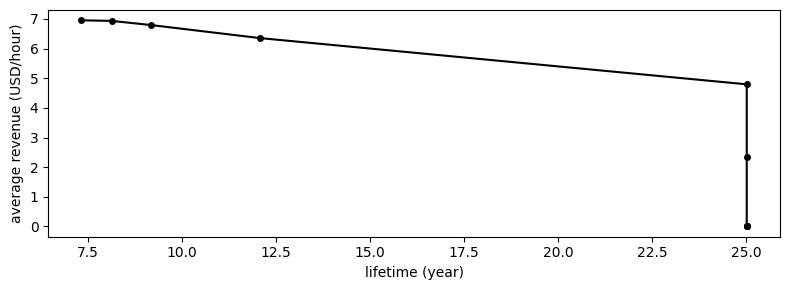

In [50]:
output_dir = "./figures"
os.makedirs(output_dir, exist_ok=True)
file_name = 'tradeoff_curve.pdf'
file_path = os.path.join(output_dir, file_name)
lifetimes = np.array(bls)
average_hourly_revenues = np.zeros((len(bvs)))
for j in range(len(bvs)):
    average_hourly_revenues[j] = np.mean(bvs[j]['revenue'])
fig, axes = plt.subplots(1, 1, figsize=(8, 3))
axes.plot(lifetimes, average_hourly_revenues, color = 'black', linestyle = 'solid', marker = 'o', markersize = 4)
axes.set_xlabel('lifetime (year)')
axes.set_ylabel('average revenue (USD/hour)')
axes.grid(False)
plt.tight_layout()
#plt.savefig(file_path, bbox_inches='tight')
plt.show()

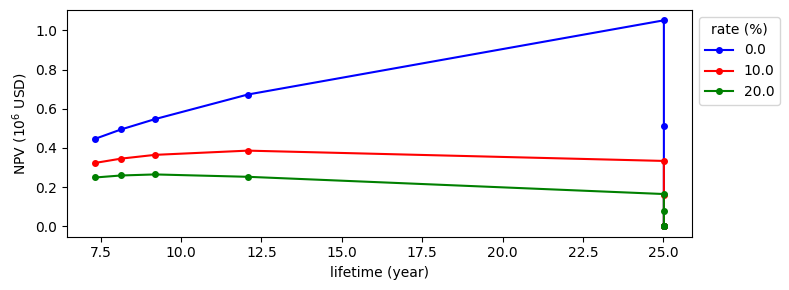

In [51]:
pbs = []
for j in range(len(bvs)):
    pbs.append(bvs[j]['revenue'])

def calculate_npv(revenue, annual_rate):
    hours_per_year = 365 * 24
    t = np.arange(1, len(revenue) + 1)
    discount_factors = (1 + annual_rate) ** (-t / hours_per_year)
    npv = np.sum(revenue * discount_factors)
    return npv

def calculate_npv_metrics(pbs, rates):
    num_pbs = len(pbs)
    num_rates = len(rates)
    total_npv = np.zeros((num_pbs, num_rates))
    average_npv_hourly = np.zeros((num_pbs, num_rates))
    cumsum_npv_revenues = [[] for _ in range(num_pbs)]
    
    for j in range(num_pbs):
        for k in range(num_rates):
            revenue = pbs[j]
            rate = rates[k]
            npv = calculate_npv(revenue, rate)
            total_npv[j, k] = npv
            average_npv_hourly[j, k] = npv / len(revenue)
            discount_factors = (1 + rate) ** (-np.arange(1, len(revenue) + 1) / (365 * 24))
            discounted_revenue = revenue * discount_factors
            cumsum_npv_revenues[j].append(np.cumsum(discounted_revenue))
    
    return total_npv, average_npv_hourly, cumsum_npv_revenues

rates = np.array([0.00, 0.1, 0.2])
total_npv, average_npv_hourly, cumsum_npv_revenues = calculate_npv_metrics(pbs, rates)

output_dir = "./figures"
os.makedirs(output_dir, exist_ok=True)
file_name = 'net_present_value.pdf'
file_path = os.path.join(output_dir, file_name)
fig, axes = plt.subplots(1, 1, figsize=(8, 3))
cmap = coolwarm
colors = ['blue', 'red', 'green']
for j, rate in enumerate(rates):
    axes.plot(lifetimes, total_npv[:, j]/1e6,
              color=colors[j], linestyle='solid',
              marker='o', markersize=4,
              label=f"{rate*100:.1f}")
axes.set_xlabel('lifetime (year)')
#axes.set_xlim([0.0, 22])
axes.set_ylabel(r'NPV ($10^6$ USD)')
axes.legend(title='rate (%)', loc='upper left', bbox_to_anchor=(1, 1))
axes.grid(False)
plt.tight_layout()
#plt.savefig(file_path, bbox_inches='tight')
plt.show()

In [52]:
k = 1
battery_variables = bvs[k]
cell_variables = cvs[k]
revenue = battery_variables['revenue']
p = battery_variables['p']
hat_p = battery_variables['hat_p']
tilde_b = cell_variables['tilde_b']
tilde_q = cell_variables['tilde_q']
tilde_Q = cell_variables['tilde_Q']
tilde_delta_q = cell_variables['tilde_delta_q']
tilde_hat_q = cell_variables['tilde_hat_q']
l = cell_variables['l']
ah = cell_variables['ah']
mu_one_plus_nu_q = cell_variables['mu_one_plus_nu_q']
Sigma_rho = cell_variables['Sigma_rho']
tilde_b = tilde_b*cell_constants['cons_delta']*cell_constants['tilde_V']*cell_constants['N']

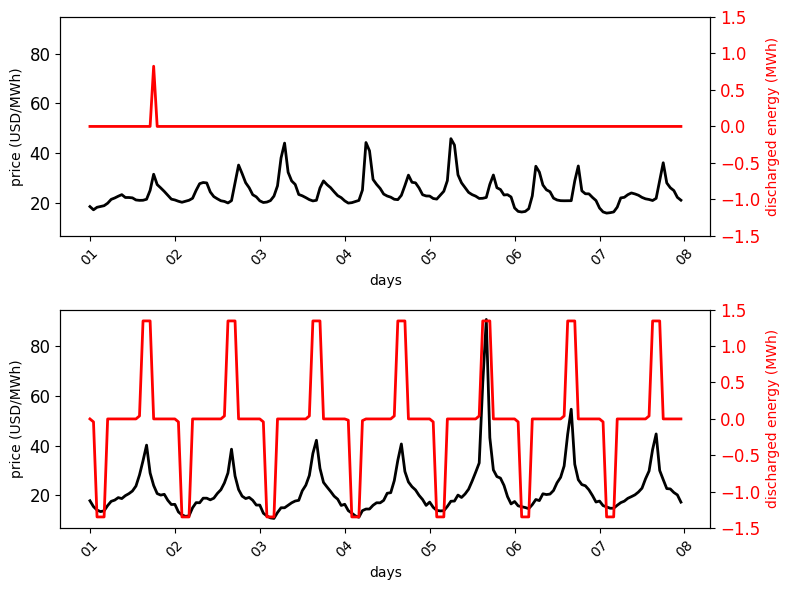

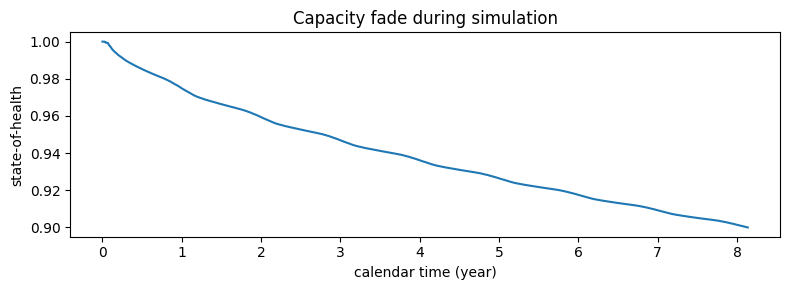

In [53]:
output_dir = "./figures"
os.makedirs(output_dir, exist_ok=True)
file_name = 'weekly_profile_arbitrage.pdf'
file_path = os.path.join(output_dir, file_name)
times_jan = pd.date_range(start = '2012-01-01 00:00', end = '2012-01-07 23:00', freq='h')
times_jun = pd.date_range(start = '2012-06-01 00:00', end = '2012-06-07 23:00', freq='h')
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharey=True)
axes[0].plot(times_jan, p[:24*7], label=r'$p_t$', color='black', linewidth=2, zorder=1)
axes[0].set_xlabel('days')
axes[0].set_ylabel('price (USD/MWh)', color="black")
axes[0].tick_params(axis='y', which='major', labelsize=12, labelcolor='black')
axes[0].grid(False)
ax2 = axes[0].twinx()
ax2.plot(times_jan, tilde_b[:24*7], label=r'$\tilde b_t$', color='red', linewidth=2, zorder=2)
ax2.set_ylabel('discharged energy (MWh)', color='red') 
ax2.tick_params(axis='y', labelcolor='red', labelsize=12)
axes[0].xaxis.set_major_formatter(DateFormatter('%d'))
axes[0].tick_params(axis='x', rotation=45)
ax2.set_ylim([-1.5, 1.5])

axes[1].plot(times_jan, p[24*151:24*158], label=r'$p_t$', color='black', linewidth=2, zorder=1)
axes[1].set_xlabel('days')
axes[1].set_ylabel('price (USD/MWh)', color='black')
axes[1].tick_params(axis='y', which='major', labelsize=12, labelcolor='black')
axes[1].grid(False)
ax4 = axes[1].twinx()
ax4.plot(times_jan, tilde_b[24*151:24*158], label=r'$\tilde b_t$', color='red', linewidth=2, zorder=2)
ax4.set_ylabel('discharged energy (MWh)', color='red') 
ax4.tick_params(axis='y', labelcolor='red', labelsize=12)
axes[1].xaxis.set_major_formatter(DateFormatter('%d'))
axes[1].tick_params(axis='x', rotation=45)
ax4.set_ylim([-1.5, 1.5])
plt.tight_layout()
#plt.savefig(file_path, bbox_inches='tight')
plt.show()


# ---------- NEW : SoH trajectory ----------
years = np.arange(len(tilde_Q)) / (365*24*(1/cell_constants['cons_delta']))
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(years, tilde_Q / cell_constants['tilde_Q_1'])
ax.set_xlabel('calendar time (year)')
ax.set_ylabel('state-of-health')
ax.set_title('Capacity fade during simulation')
ax.grid(False)
fig.tight_layout()
fig.savefig('./figures/SoH_trajectory.pdf')
plt.show()

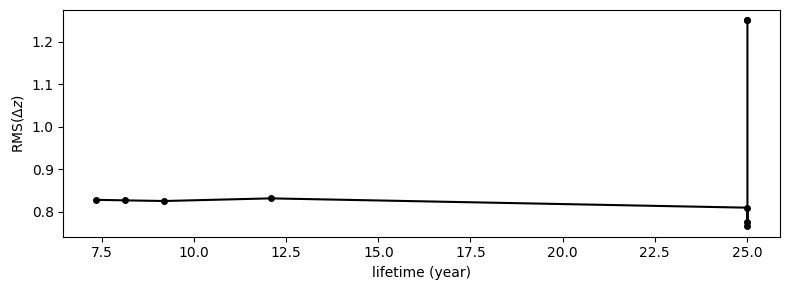

In [54]:
# ─── 平滑器的 Δz 均方根 ───
rms_delta_z = np.array([
    np.sqrt(np.mean(cv['tilde_delta_q']**2))
    for cv in cvs
])

file_name = 'tradeoff_curve_smoothing.pdf'
file_path = os.path.join(output_dir, file_name)
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(lifetimes, rms_delta_z,
        color='black', linestyle='solid',
        marker='o', markersize=4)
ax.set_xlabel('lifetime (year)')
ax.set_ylabel(r'RMS($\Delta z$)')
ax.grid(False)
fig.tight_layout()
# fig.savefig(file_path, bbox_inches='tight')
plt.show()
